<a href="https://colab.research.google.com/github/SevilayMuni/PySpark-Machine-Learning-Big-Data-Sales-Forecast/blob/main/Forecast_Kaggle_Sticker_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast Sticker Sales by PySpark and Machine Learning

For this challenge, we will predict multiple years worth of sales for various Kaggle-branded stickers from different fictitious stores in different countries. This dataset is completely synthetic, but contains many effects seen in real-world data, e.g., weekend and holiday effect, seasonality, etc.

## Explanatory Data Analysis

### Libraries

In [ ]:
# Import required liraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
from datetime import datetime, date, timedelta

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import col, when, avg, sum, count, countDistinct
from pyspark.sql.functions import expr, corr, desc
from pyspark.sql.functions import dayofweek, month, lag
from pyspark.sql.functions import sin, cos, lit
from pyspark.sql.functions import year, when, dayofmonth

from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer

### Spark Session

In [ ]:
# Create Spark Session
spark = SparkSession.builder.appName('StickerSale').getOrCreate()
spark

### Loading Data

In [ ]:
df_train = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/PySpark/Kaggle-Competition/data/StickerSaletrain.csv',
                          header = True, inferSchema = True)
df_train.show(5)

+---+----------+-------+-----------------+------------------+--------+
| id|      date|country|            store|           product|num_sold|
+---+----------+-------+-----------------+------------------+--------+
|  0|2010-01-01| Canada|Discount Stickers| Holographic Goose|    NULL|
|  1|2010-01-01| Canada|Discount Stickers|            Kaggle|   973.0|
|  2|2010-01-01| Canada|Discount Stickers|      Kaggle Tiers|   906.0|
|  3|2010-01-01| Canada|Discount Stickers|          Kerneler|   423.0|
|  4|2010-01-01| Canada|Discount Stickers|Kerneler Dark Mode|   491.0|
+---+----------+-------+-----------------+------------------+--------+
only showing top 5 rows



### Initial Data Exploration

In [ ]:
df_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- country: string (nullable = true)
 |-- store: string (nullable = true)
 |-- product: string (nullable = true)
 |-- num_sold: double (nullable = true)



In [ ]:
print(f"Dataset Shape: {df_train.count()}, {len(df_train.columns)}")

Dataset Shape: 230130, 6


In [ ]:
df_train.describe('num_sold').show()

+-------+-----------------+
|summary|         num_sold|
+-------+-----------------+
|  count|           221259|
|   mean| 752.527381937006|
| stddev|690.1654449850453|
|    min|              5.0|
|    max|           5939.0|
+-------+-----------------+



In [ ]:
# Count missing values in each column
df_train.select([count(when(col(c).isNull(), 1)).alias(c) for c in df_train.columns]).show()

+---+----+-------+-----+-------+--------+
| id|date|country|store|product|num_sold|
+---+----+-------+-----+-------+--------+
|  0|   0|      0|    0|      0|    8871|
+---+----+-------+-----+-------+--------+



---> 8871 missing values in num_sold columns -- large # to drop

---> Are they accumulated in certain country or store? --- **Mean could be used to impute**

In [ ]:
# Check unique categories
df_train.select(countDistinct('country').alias('Country #'),
                countDistinct('store').alias(' Unique Store #'),
                countDistinct('product').alias('Unique Product #')).show()

+---------+---------------+----------------+
|Country #| Unique Store #|Unique Product #|
+---------+---------------+----------------+
|        6|              3|               5|
+---------+---------------+----------------+



In [ ]:
df_train.groupby('country').count().show(),
df_train.groupby('store').count().show(),
df_train.groupby('product').count().show()

+---------+-----+
|  country|count|
+---------+-----+
|Singapore|38355|
|  Finland|38355|
|    Italy|38355|
|   Norway|38355|
|   Canada|38355|
|    Kenya|38355|
+---------+-----+

+--------------------+-----+
|               store|count|
+--------------------+-----+
|   Stickers for Less|76710|
|   Discount Stickers|76710|
|Premium Sticker Mart|76710|
+--------------------+-----+

+------------------+-----+
|           product|count|
+------------------+-----+
|            Kaggle|46026|
|      Kaggle Tiers|46026|
|          Kerneler|46026|
|Kerneler Dark Mode|46026|
| Holographic Goose|46026|
+------------------+-----+



In [ ]:
# Parse date into columns
df_train = df_train.withColumn('year', year('date'))
df_train = df_train.withColumn('month', month('date'))
df_train = df_train.withColumn('weekday', dayofweek('date'))
df_train = df_train.withColumn('is_weekend', when((col('weekday') == 6) | (col('weekday') == 7), 1).otherwise(0))
df_train.show(10)

+---+----------+-------+-----------------+------------------+--------+----+-----+-------+----------+
| id|      date|country|            store|           product|num_sold|year|month|weekday|is_weekend|
+---+----------+-------+-----------------+------------------+--------+----+-----+-------+----------+
|  0|2010-01-01| Canada|Discount Stickers| Holographic Goose|    NULL|2010|    1|      6|         1|
|  1|2010-01-01| Canada|Discount Stickers|            Kaggle|   973.0|2010|    1|      6|         1|
|  2|2010-01-01| Canada|Discount Stickers|      Kaggle Tiers|   906.0|2010|    1|      6|         1|
|  3|2010-01-01| Canada|Discount Stickers|          Kerneler|   423.0|2010|    1|      6|         1|
|  4|2010-01-01| Canada|Discount Stickers|Kerneler Dark Mode|   491.0|2010|    1|      6|         1|
|  5|2010-01-01| Canada|Stickers for Less| Holographic Goose|   300.0|2010|    1|      6|         1|
|  6|2010-01-01| Canada|Stickers for Less|            Kaggle|  1837.0|2010|    1|      6|  

In [ ]:
df_train.groupby('year').count().show(),
df_train.groupby('month').count().show(),
df_train.groupby('is_weekend').count().show()

+----+-----+
|year|count|
+----+-----+
|2013|32850|
|2014|32850|
|2012|32940|
|2010|32850|
|2011|32850|
|2015|32850|
|2016|32940|
+----+-----+

+-----+-----+
|month|count|
+-----+-----+
|   12|19530|
|    1|19530|
|    6|18900|
|    3|19530|
|    5|19530|
|    9|18900|
|    4|18900|
|    8|19530|
|    7|19530|
|   10|19530|
|   11|18900|
|    2|17820|
+-----+-----+

+----------+------+
|is_weekend| count|
+----------+------+
|         1| 65880|
|         0|164250|
+----------+------+



**Popular E-Commerce Holidays by Country**  
Country	--- Holidays  
***Singapore***	New Year, Chinese New Year, Singles’ Day, Christmas  
***Finland*** Christmas, Black Friday, Independence Day  
***Italy***	Christmas, Easter, Epiphany  
***Norway***	Christmas, Black Friday, Constitution Day    
***Canada***	Christmas, Boxing Day, Thanksgiving   
***Kenya***	Christmas, Jamhuri Day, Black Friday   

In [ ]:
# Define the holiday dates
holiday_dates = {
    'Singapore': [('01-01', 'New Year'), ('02-10', 'Chinese New Year'), ('11-11', 'Singles’ Day'), ('12-25', 'Christmas')],
    'Finland': [('12-25', 'Christmas'), ('11-24', 'Black Friday'), ('12-06', 'Independence Day')],
    'Italy': [('12-25', 'Christmas'), ('04-09', 'Easter'), ('01-06', 'Epiphany')],
    'Norway': [('12-25', 'Christmas'), ('11-24', 'Black Friday'), ('05-17', 'Constitution Day')],
    'Canada': [('12-25', 'Christmas'), ('12-26', 'Boxing Day'), ('10-09', 'Thanksgiving')],
    'Kenya': [('12-25', 'Christmas'), ('12-12', 'Jamhuri Day'), ('11-24', 'Black Friday')]
}

# Create a function to determine if a date is within the holiday interval
def is_holiday(country, date_value):
    # Ensure date_value is a string
    if isinstance(date_value, date):  # Check if it's a date object
        date_value = date_value.strftime('%Y-%m-%d')

    # Parse holidays and date
    country_holidays = [h for h in holiday_dates.get(country, [])]
    date_obj = datetime.strptime(date_value, '%Y-%m-%d')

    for month_day, _ in country_holidays:
        holiday_date = datetime.strptime(f"{date_obj.year}-{month_day}", '%Y-%m-%d')
        if holiday_date - timedelta(days=7) <= date_obj <= holiday_date:
            return 1
    return 0

# Register the function as a UDF
is_holiday_udf = F.udf(is_holiday, IntegerType())

# Add the is_holiday column to the DataFrame
df_train_with_holiday = df_train.withColumn(
    'is_holiday',
    is_holiday_udf(F.col('country'), F.col('date')))

# Show the updated DataFrame
df_train_with_holiday.show()

+---+----------+-------+--------------------+------------------+--------+----+-----+-------+----------+----------+
| id|      date|country|               store|           product|num_sold|year|month|weekday|is_weekend|is_holiday|
+---+----------+-------+--------------------+------------------+--------+----+-----+-------+----------+----------+
|  0|2010-01-01| Canada|   Discount Stickers| Holographic Goose|    NULL|2010|    1|      6|         1|         0|
|  1|2010-01-01| Canada|   Discount Stickers|            Kaggle|   973.0|2010|    1|      6|         1|         0|
|  2|2010-01-01| Canada|   Discount Stickers|      Kaggle Tiers|   906.0|2010|    1|      6|         1|         0|
|  3|2010-01-01| Canada|   Discount Stickers|          Kerneler|   423.0|2010|    1|      6|         1|         0|
|  4|2010-01-01| Canada|   Discount Stickers|Kerneler Dark Mode|   491.0|2010|    1|      6|         1|         0|
|  5|2010-01-01| Canada|   Stickers for Less| Holographic Goose|   300.0|2010|  

In [ ]:
df_train_with_holiday.groupBy('country', 'is_holiday').count().show()

+---------+----------+-----+
|  country|is_holiday|count|
+---------+----------+-----+
|    Kenya|         1| 2520|
|   Norway|         1| 2520|
|    Italy|         0|36045|
|Singapore|         1| 2625|
|   Norway|         0|35835|
|  Finland|         0|35835|
|    Italy|         1| 2310|
|    Kenya|         0|35835|
|   Canada|         0|36570|
|Singapore|         0|35730|
|  Finland|         1| 2520|
|   Canada|         1| 1785|
+---------+----------+-----+



In [ ]:
# Verify holiday for Singapore
df_train_with_holiday.filter(
    (F.col('country') == 'Singapore') & (F.col('date') == '2010-12-25')).show(5)

# Verify a non-holiday date
df_train_with_holiday.filter(
    (F.col('country') == 'Singapore') & (F.col('date') == '2010-12-10')).show(5)

+-----+----------+---------+-----------------+------------------+--------+----+-----+-------+----------+----------+
|   id|      date|  country|            store|           product|num_sold|year|month|weekday|is_weekend|is_holiday|
+-----+----------+---------+-----------------+------------------+--------+----+-----+-------+----------+----------+
|32295|2010-12-25|Singapore|Discount Stickers| Holographic Goose|   116.0|2010|   12|      7|         1|         1|
|32296|2010-12-25|Singapore|Discount Stickers|            Kaggle|   742.0|2010|   12|      7|         1|         1|
|32297|2010-12-25|Singapore|Discount Stickers|      Kaggle Tiers|   580.0|2010|   12|      7|         1|         1|
|32298|2010-12-25|Singapore|Discount Stickers|          Kerneler|   353.0|2010|   12|      7|         1|         1|
|32299|2010-12-25|Singapore|Discount Stickers|Kerneler Dark Mode|   387.0|2010|   12|      7|         1|         1|
+-----+----------+---------+-----------------+------------------+-------

In [ ]:
# Impute missing values in num_column

# Calculate the mean of `num_sold` grouped by `country` and `store`
mean_values = df_train_with_holiday.groupBy('country', 'store').agg(
    F.mean('num_sold').alias('mean_num_sold'))

# Join the mean values back to the original DataFrame
df_with_means = df_train_with_holiday.join(
    mean_values,
    on = ['country', 'store'],
    how = 'left')

# Impute missing values in `num_sold` with the calculated mean
df_imputed = df_with_means.withColumn(
    'num_sold',
    F.when(F.col('num_sold').isNull(), F.col('mean_num_sold')).otherwise(F.col('num_sold'))
).drop('mean_num_sold')  # Drop the intermediate column since not needed

df_imputed.show(5)

+-------+-----------------+---+----------+------------------+-----------------+----+-----+-------+----------+----------+
|country|            store| id|      date|           product|         num_sold|year|month|weekday|is_weekend|is_holiday|
+-------+-----------------+---+----------+------------------+-----------------+----+-----+-------+----------+----------+
| Canada|Discount Stickers|  0|2010-01-01| Holographic Goose|502.4214334604478|2010|    1|      6|         1|         0|
| Canada|Discount Stickers|  1|2010-01-01|            Kaggle|            973.0|2010|    1|      6|         1|         0|
| Canada|Discount Stickers|  2|2010-01-01|      Kaggle Tiers|            906.0|2010|    1|      6|         1|         0|
| Canada|Discount Stickers|  3|2010-01-01|          Kerneler|            423.0|2010|    1|      6|         1|         0|
| Canada|Discount Stickers|  4|2010-01-01|Kerneler Dark Mode|            491.0|2010|    1|      6|         1|         0|
+-------+-----------------+---+-

In [ ]:
# Verify the results --> should show no rows with NULL
df_imputed.filter(F.col('num_sold').isNull()).show()

+-------+-----+---+----+-------+--------+----+-----+-------+----------+----------+
|country|store| id|date|product|num_sold|year|month|weekday|is_weekend|is_holiday|
+-------+-----+---+----+-------+--------+----+-----+-------+----------+----------+
+-------+-----+---+----+-------+--------+----+-----+-------+----------+----------+



In [ ]:
print(f"Dataset Shape: {df_imputed.count()}, {len(df_imputed.columns)}")

Dataset Shape: 230130, 11


In [ ]:
df_imputed.dtypes

[('country', 'string'),
 ('store', 'string'),
 ('id', 'int'),
 ('date', 'date'),
 ('product', 'string'),
 ('num_sold', 'double'),
 ('year', 'int'),
 ('month', 'int'),
 ('weekday', 'int'),
 ('is_weekend', 'int'),
 ('is_holiday', 'int')]

### Visualizations with PySpark Frame

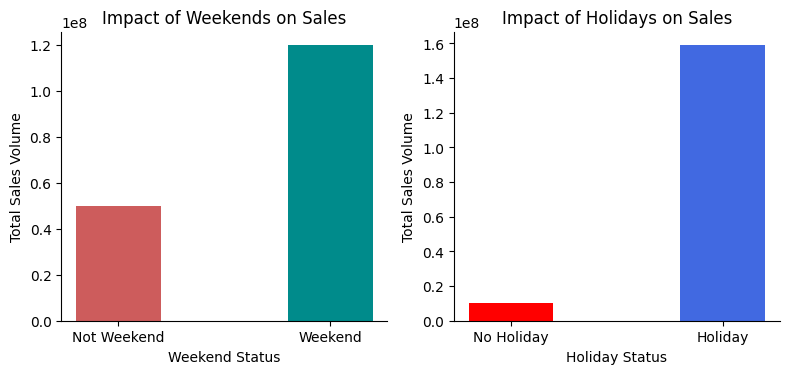

In [ ]:
# Separate plots
fig, axes = plt.subplots(1, 2, figsize = (8, 4))

# Weekend Impact
weekend_sales = df_imputed.groupBy('is_weekend').sum('num_sold').collect()
labels = ['Not Weekend', 'Weekend']
sales = [row['sum(num_sold)'] for row in weekend_sales]
axes[0].bar(labels, sales, color = ['indianred', 'darkcyan'], width = 0.4)
axes[0].set_xlabel('Weekend Status')
axes[0].set_ylabel('Total Sales Volume')
axes[0].set_title('Impact of Weekends on Sales')

# Holiday Impact
holiday_sales = df_imputed.groupBy('is_holiday').sum('num_sold').collect()
labels = ['No Holiday', 'Holiday']
sales = [row['sum(num_sold)'] for row in holiday_sales]
axes[1].bar(labels, sales, color = ['red', 'royalblue'], width = 0.4)
axes[1].set_xlabel('Holiday Status')
axes[1].set_ylabel('Total Sales Volume')
axes[1].set_title('Impact of Holidays on Sales')

plt.tight_layout()
sns.despine()
plt.show()

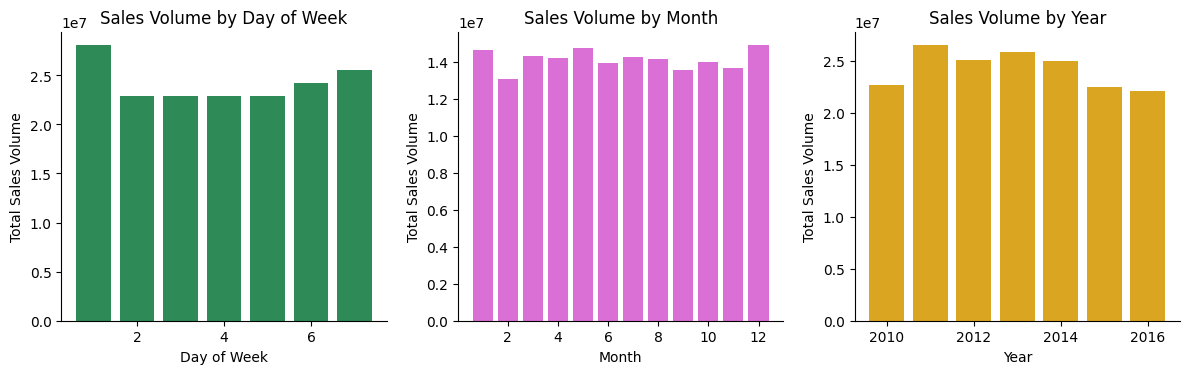

In [ ]:
# Separate plots
fig, axes = plt.subplots(1, 3, figsize = (12, 4))

# Sales by Day of Week
sales_by_day = df_imputed.groupBy('weekday').sum('num_sold').collect()
days = [row['weekday'] for row in sales_by_day]
sales = [row['sum(num_sold)'] for row in sales_by_day]
axes[0].bar(days, sales, color = 'seagreen')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Total Sales Volume')
axes[0].set_title('Sales Volume by Day of Week')

# Sales by Month
sales_by_month = df_imputed.groupBy('month').sum('num_sold').collect()
months = [row['month'] for row in sales_by_month]
sales = [row['sum(num_sold)'] for row in sales_by_month]
axes[1].bar(months, sales, color = 'orchid')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Sales Volume')
axes[1].set_title('Sales Volume by Month')

# Sales by Year
sales_by_year = df_imputed.groupBy('year').sum('num_sold').collect()
years = [row['year'] for row in sales_by_year]
sales = [row['sum(num_sold)'] for row in sales_by_year]
axes[2].bar(years, sales, color = 'goldenrod')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Total Sales Volume')
axes[2].set_title('Sales Volume by Year')

plt.tight_layout()
sns.despine()
plt.show()

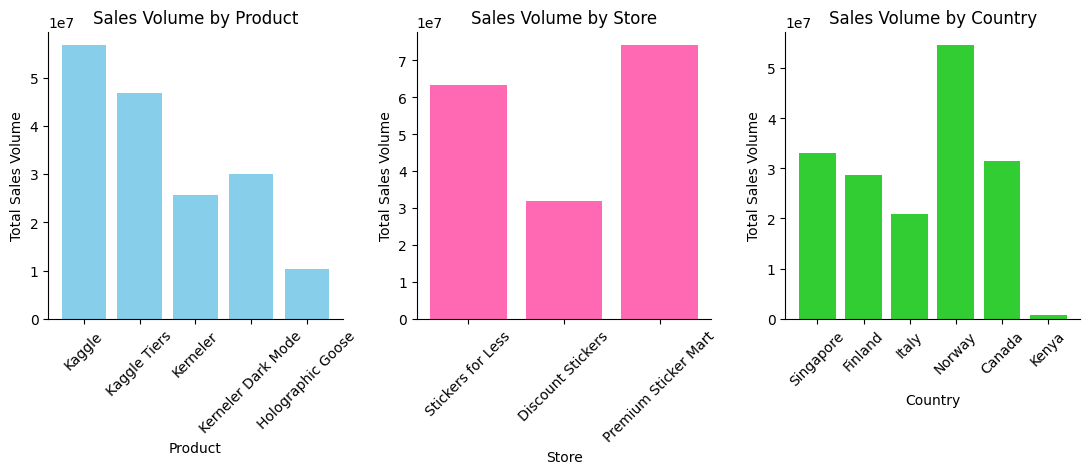

In [ ]:
# Separate plots
fig, axes = plt.subplots(1, 3, figsize = (11, 5))

# Sales by Product
sales_by_product = df_imputed.groupBy('product').sum('num_sold').collect()
products = [row['product'] for row in sales_by_product]
sales = [row['sum(num_sold)'] for row in sales_by_product]
axes[0].bar(products, sales, color = 'skyblue')
axes[0].set_xlabel('Product')
axes[0].set_ylabel('Total Sales Volume')
axes[0].set_title('Sales Volume by Product')
axes[0].set_xticks(np.arange(len(products)))
axes[0].set_xticklabels(products, rotation = 45)

# Sales by Store
sales_by_store = df_imputed.groupBy('store').sum('num_sold').collect()
stores = [row['store'] for row in sales_by_store]
sales = [row['sum(num_sold)'] for row in sales_by_store]
axes[1].bar(stores, sales, color = 'hotpink')
axes[1].set_xlabel('Store')
axes[1].set_ylabel('Total Sales Volume')
axes[1].set_title('Sales Volume by Store')
axes[1].set_xticks(np.arange(len(stores)))
axes[1].set_xticklabels(stores, rotation = 45)

# Sales by Country
sales_by_country = df_imputed.groupBy('country').sum('num_sold').collect()
countries = [row['country'] for row in sales_by_country]
sales = [row['sum(num_sold)'] for row in sales_by_country]
axes[2].bar(countries, sales, color = 'limegreen')
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Total Sales Volume')
axes[2].set_title('Sales Volume by Country')
axes[2].set_xticks(np.arange(len(countries)))
axes[2].set_xticklabels(countries, rotation = 45)

plt.tight_layout()
sns.despine()
plt.show()

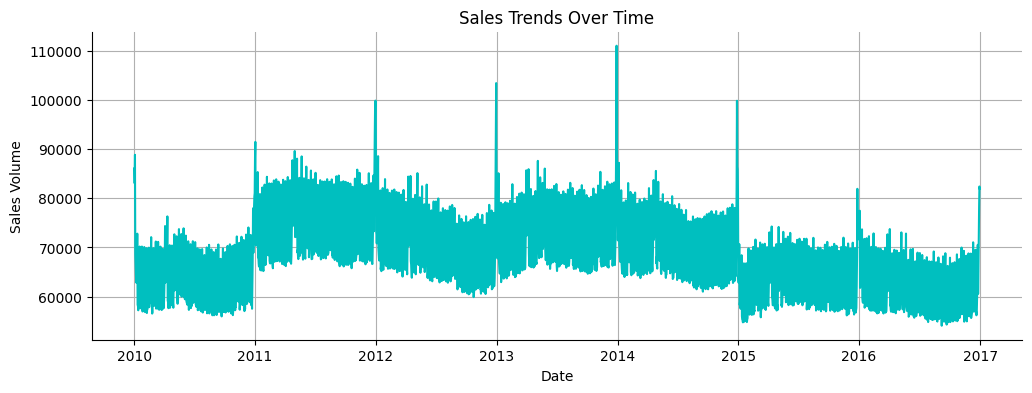

In [ ]:
# Sales Trends Over Time
plt.figure(figsize = (12, 4))
sales_trend = df_imputed.groupby('date').sum('num_sold').orderBy('date').collect()
dates = [row['date'] for row in sales_trend]
sales = [row['sum(num_sold)'] for row in sales_trend]
plt.plot(dates, sales, linestyle = '-', color = 'c')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.grid(True)
sns.despine()
plt.show()

### Feature Engineering

In [ ]:
# Category Columns Indexing
indexer_store = StringIndexer(inputCol = 'store', outputCol = 'store_index')
indexer_country = StringIndexer(inputCol = 'country', outputCol = 'country_index')
indexer_product = StringIndexer(inputCol = 'product', outputCol = 'product_index')
df_imputed = indexer_store.fit(df_imputed).transform(df_imputed)
df_imputed = indexer_country.fit(df_imputed).transform(df_imputed)
df_imputed = indexer_product.fit(df_imputed).transform(df_imputed)

In [ ]:
# Create new column as 'holiday_store_interaction'
df_imputed = df_imputed.withColumn('holiday_store_interaction', col('is_holiday') * col('store_index'))
df_imputed.show(5)

+-------+-----------------+---+----------+------------------+-----------------+----+-----+-------+----------+----------+-----------+-------------+-------------+-------------------------+
|country|            store| id|      date|           product|         num_sold|year|month|weekday|is_weekend|is_holiday|store_index|country_index|product_index|holiday_store_interaction|
+-------+-----------------+---+----------+------------------+-----------------+----+-----+-------+----------+----------+-----------+-------------+-------------+-------------------------+
| Canada|Discount Stickers|  0|2010-01-01| Holographic Goose|502.4214334604478|2010|    1|      6|         1|         0|        0.0|          0.0|          0.0|                      0.0|
| Canada|Discount Stickers|  1|2010-01-01|            Kaggle|            973.0|2010|    1|      6|         1|         0|        0.0|          0.0|          1.0|                      0.0|
| Canada|Discount Stickers|  2|2010-01-01|      Kaggle Tiers|    

In [ ]:
# Cyclical Encoding
df_imputed = df_imputed.withColumn("day_sin", sin(col("weekday") * (2 * 3.141592653589793 / lit(31))))
df_imputed = df_imputed.withColumn("day_cos", cos(col("weekday") * (2 * 3.141592653589793 / lit(31))))
df_imputed = df_imputed.withColumn("month_sin", sin(col("month") * (2 * 3.141592653589793 / lit(12))))
df_imputed = df_imputed.withColumn("month_cos", cos(col("month") * (2 * 3.141592653589793 / lit(12))))
df_imputed = df_imputed.withColumn("year_sin", sin(col("year") * (2 * 3.141592653589793 / lit(1))))
df_imputed = df_imputed.withColumn("year_cos", cos(col("year") * (2 * 3.141592653589793 / lit(1))))

df_imputed.show()

+-------+--------------------+---+----------+------------------+-----------------+----+-----+-------+----------+----------+-----------+-------------+-------------+-------------------------+------------------+------------------+-------------------+------------------+--------------------+--------+
|country|               store| id|      date|           product|         num_sold|year|month|weekday|is_weekend|is_holiday|store_index|country_index|product_index|holiday_store_interaction|           day_sin|           day_cos|          month_sin|         month_cos|            year_sin|year_cos|
+-------+--------------------+---+----------+------------------+-----------------+----+-----+-------+----------+----------+-----------+-------------+-------------+-------------------------+------------------+------------------+-------------------+------------------+--------------------+--------+
| Canada|   Discount Stickers|  0|2010-01-01| Holographic Goose|502.4214334604478|2010|    1|      6|        

### PySpark Frame to Pandas

In [ ]:
# Convert the data from PySpark frame to Pandas DF
df = df_imputed.toPandas()
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   country                    230130 non-null  object        
 1   store                      230130 non-null  object        
 2   id                         230130 non-null  int32         
 3   date                       230130 non-null  datetime64[ns]
 4   product                    230130 non-null  object        
 5   num_sold                   230130 non-null  float64       
 6   year                       230130 non-null  int32         
 7   month                      230130 non-null  int32         
 8   weekday                    230130 non-null  int32         
 9   is_weekend                 230130 non-null  int32         
 10  is_holiday                 230130 non-null  int32         
 11  store_index                230130 non-null  float64 

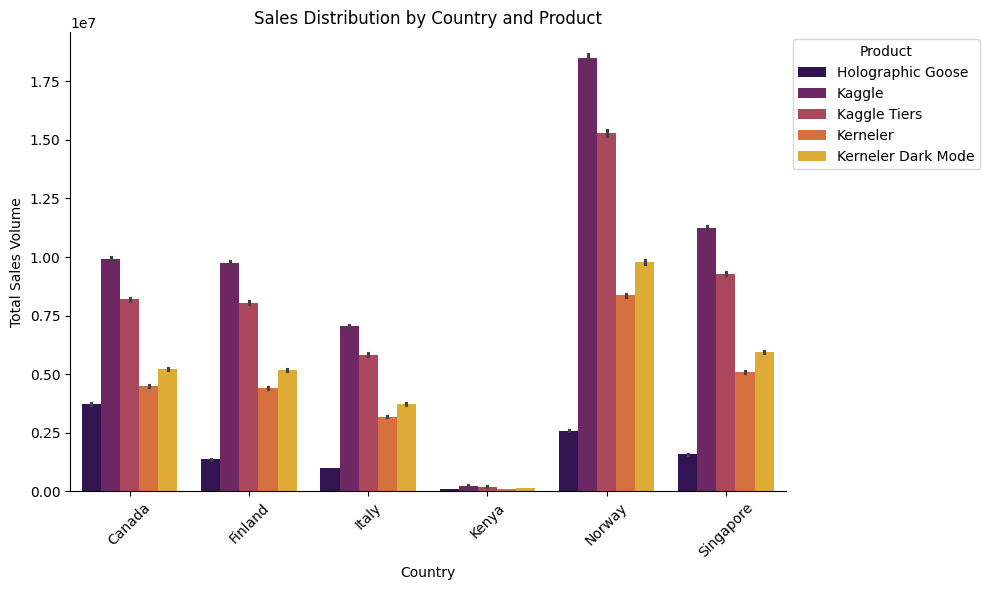

In [ ]:
# Plot with corrected estimator
plt.figure(figsize = (10, 6))
sns.barplot(data = df, x = 'country', y = 'num_sold',
            hue = 'product', estimator = np.sum, palette = 'inferno')
plt.title('Sales Distribution by Country and Product')
plt.xlabel('Country')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45)
plt.legend(title = 'Product', bbox_to_anchor = (1, 1), loc = 'upper left')

sns.despine()
plt.tight_layout()
plt.show()

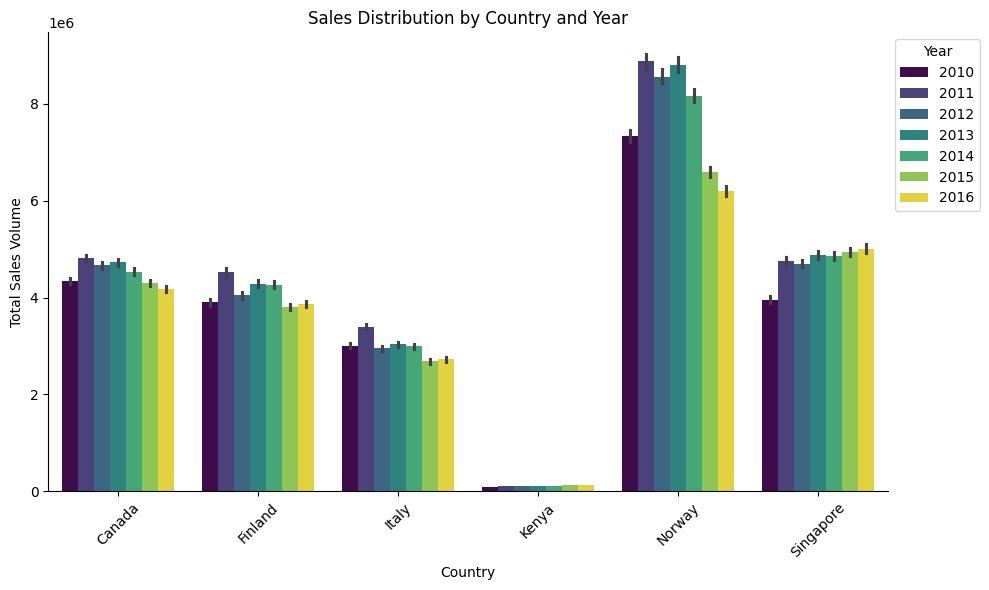

In [ ]:
# Plot with corrected estimator
plt.figure(figsize = (10, 6))
sns.barplot(data = df, x = 'country', y = 'num_sold',
            hue = 'year', estimator = np.sum, palette = 'viridis')
plt.title('Sales Distribution by Country and Year')
plt.xlabel('Country')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation = 45)
plt.legend(title = 'Year', bbox_to_anchor = (1, 1), loc = 'upper left')

sns.despine()
plt.tight_layout()
plt.show()

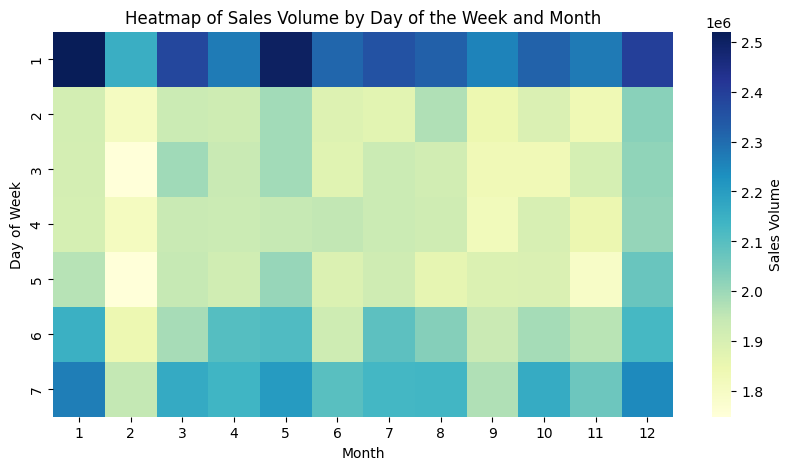

In [ ]:
# Heatmap of Sales Volume by Day of the Week and Month
heatmap_data = df.groupby(['weekday', 'month'])['num_sold'].sum().unstack()
plt.figure(figsize = (10, 5))
sns.heatmap(heatmap_data, annot = False, cmap = 'YlGnBu',
            cbar_kws = {'label': 'Sales Volume'})
plt.title('Heatmap of Sales Volume by Day of the Week and Month')
plt.xlabel('Month')
plt.ylabel('Day of Week')
plt.show()

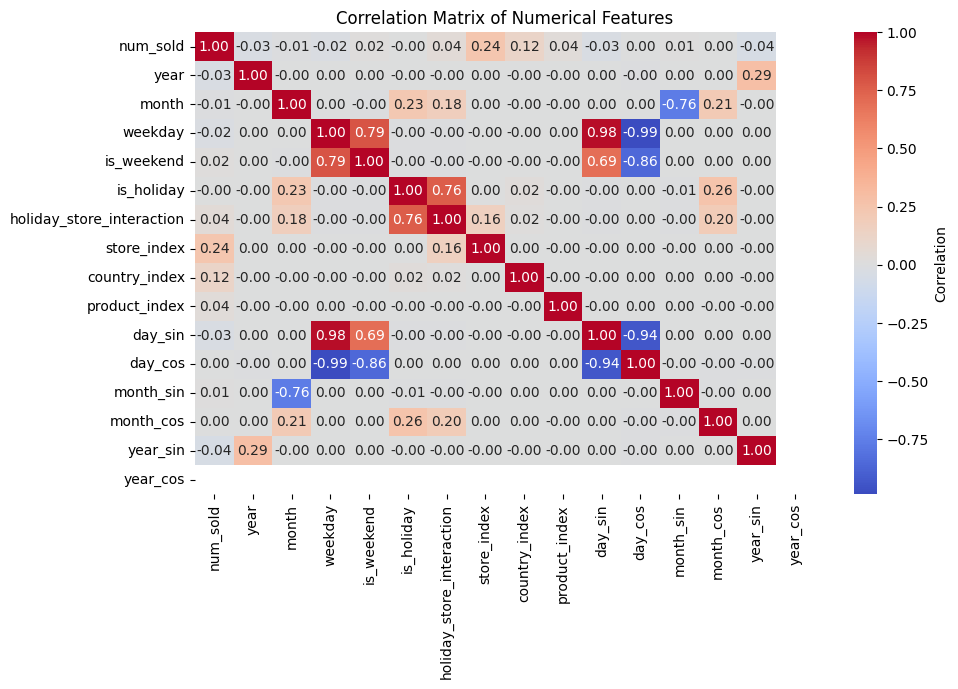

In [ ]:
# Correlation Heatmap
plt.figure(figsize = (10, 6))
correlation_matrix = df[['num_sold', 'year', 'month', 'weekday', 'is_weekend',
                         'is_holiday', 'holiday_store_interaction',
                         'store_index', 'country_index', 'product_index',
                         'day_sin', 'day_cos', 'month_sin', 'month_cos',
                         'year_sin', 'year_cos']].corr()
sns.heatmap(correlation_matrix, annot = True, fmt = '.2f',
            cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

***Remarks:***  
The zero correlation, in this case, **highlights the limitations of Pearson correlation for binary or categorical features**.   
To capture the real impact of holidays, we should explore group-wise analysis, create interaction terms, or use nonlinear modeling approaches to model conditional relationships effectively.

## Prediction by Machine Learning

### Coding Environment

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import optuna

### XGBoost Train/Test & Optuna Hyperparameter Tuning

In [ ]:
# Define features and target variable
features = ['store_index', 'product_index', 'is_holiday', 'weekday', 'month',
            'year', 'is_weekend', 'day_sin', 'day_cos', 'month_sin',
            'month_cos', 'year_sin', 'year_cos']
target = 'num_sold'

# Step 1: Split data by country for separate modeling
countries = df['country'].unique()  # Extract unique country names

# Store results for each country
results = {}

# Loop through each country to train a separate model
for country in countries:
    print(f"Processing country: {country}")

    # Filter data for the specific country
    country_data = df[df['country'] == country]
    X = country_data[features]
    y = country_data[target]

    # Split the country-specific data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = 0.2,
                                                        random_state = 42)

    # Step 2: Define an Optuna objective function for hyperparameter tuning
    def objective(trial):
        # Define the hyperparameter search space
        param = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1400),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'random_state': 42}

        # Train an XGBoost model with the trial parameters
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train)

        # Evaluate using the MAPE on the test set
        y_pred = model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred) # Calculate MAPE
        return mape

    # Step 3: Run Optuna optimization
    print("Starting Optuna optimization...")
    study = optuna.create_study(direction = 'minimize')  # Minimize MAPE
    study.optimize(objective, n_trials = 50, show_progress_bar = True)

    # Best hyperparameters
    best_params = study.best_params
    print(f"Best params for {country}: {best_params}")

    # Step 4: Train the final model using the best parameters
    print("Training final model with best parameters...")
    final_model = xgb.XGBRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Step 5: Make predictions and evaluate the final model
    y_pred = final_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Evaluation for {country} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, R2: {r2}")

    # Step 6: Store results for each country
    results[country] = {'model': final_model,
                        'mse': mse,
                        'rmse': rmse,
                        'mae': mae,
                        'mape': mape,
                        'r2': r2,
                        'best_params': best_params}

# Step 7: Summarize results for all countries
print("\nFinal Results:")
for country, metrics in results.items():
    print(f"{country} - MSE: {metrics['mse']}, RMSE: {metrics['rmse']}, MAE: {metrics['mae']}, MAPE: {metrics['mape']}, R2: {metrics['r2']}")

[I 2025-01-30 11:12:22,007] A new study created in memory with name: no-name-bd834074-5bc0-4581-88ef-6f8eef02d843


Processing country: Canada
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:12:24,040] Trial 0 finished with value: 0.11769701123093838 and parameters: {'n_estimators': 1174, 'learning_rate': 0.04020514156803851, 'max_depth': 4, 'subsample': 0.7362974624450571, 'colsample_bytree': 0.6655237301310022}. Best is trial 0 with value: 0.11769701123093838.
[I 2025-01-30 11:12:25,281] Trial 1 finished with value: 0.13428786006068763 and parameters: {'n_estimators': 233, 'learning_rate': 0.022446766838548342, 'max_depth': 11, 'subsample': 0.5126830207195743, 'colsample_bytree': 0.6080921855770864}. Best is trial 0 with value: 0.11769701123093838.
[I 2025-01-30 11:12:51,724] Trial 2 finished with value: 0.09434204739303202 and parameters: {'n_estimators': 951, 'learning_rate': 0.04870315882139853, 'max_depth': 15, 'subsample': 0.8942078874236801, 'colsample_bytree': 0.917954583868327}. Best is trial 2 with value: 0.09434204739303202.
[I 2025-01-30 11:12:52,539] Trial 3 finished with value: 0.09856946277935004 and parameters: {'n_estimators': 323, 'learn

[I 2025-01-30 11:17:02,575] A new study created in memory with name: no-name-8a53eddd-b110-41fd-ac53-9fba6db0cae3


Evaluation for Canada - MSE: 11458.764694268875, RMSE: 107.04561968744389, MAE: 53.53729686561819, MAPE: 0.09019860012681731, R2: 0.9445178230523238
Processing country: Finland
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:17:06,083] Trial 0 finished with value: 0.060910303856618504 and parameters: {'n_estimators': 867, 'learning_rate': 0.21689776414701337, 'max_depth': 7, 'subsample': 0.9060554878336979, 'colsample_bytree': 0.7788644149607142}. Best is trial 0 with value: 0.060910303856618504.
[I 2025-01-30 11:17:27,231] Trial 1 finished with value: 0.0671787585701554 and parameters: {'n_estimators': 777, 'learning_rate': 0.1814579236278188, 'max_depth': 15, 'subsample': 0.6124034852115661, 'colsample_bytree': 0.9911675771663474}. Best is trial 0 with value: 0.060910303856618504.
[I 2025-01-30 11:17:28,545] Trial 2 finished with value: 0.05830262517201249 and parameters: {'n_estimators': 444, 'learning_rate': 0.16951011060974397, 'max_depth': 7, 'subsample': 0.7732075309565684, 'colsample_bytree': 0.5982545767294993}. Best is trial 2 with value: 0.05830262517201249.
[I 2025-01-30 11:17:30,273] Trial 3 finished with value: 0.06351523941046021 and parameters: {'n_estimators': 1370, 'learn

[I 2025-01-30 11:20:05,380] A new study created in memory with name: no-name-aecf03ae-1c6a-453f-9909-9b678f2ab776


Evaluation for Finland - MSE: 4182.204882892363, RMSE: 64.66996894148289, MAE: 39.8905176504108, MAPE: 0.05354741477689084, R2: 0.9825355650636404
Processing country: Italy
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:20:09,056] Trial 0 finished with value: 0.05961319050619285 and parameters: {'n_estimators': 1103, 'learning_rate': 0.2349278843070079, 'max_depth': 7, 'subsample': 0.6164741389432836, 'colsample_bytree': 0.8139522187667733}. Best is trial 0 with value: 0.05961319050619285.
[I 2025-01-30 11:20:10,797] Trial 1 finished with value: 0.05202576405160567 and parameters: {'n_estimators': 506, 'learning_rate': 0.04236304392045464, 'max_depth': 8, 'subsample': 0.9979656838097276, 'colsample_bytree': 0.7334402334061567}. Best is trial 1 with value: 0.05202576405160567.
[I 2025-01-30 11:20:11,563] Trial 2 finished with value: 0.05565986407539699 and parameters: {'n_estimators': 359, 'learning_rate': 0.2767572971286329, 'max_depth': 5, 'subsample': 0.6972882502417574, 'colsample_bytree': 0.5208544986408326}. Best is trial 1 with value: 0.05202576405160567.
[I 2025-01-30 11:20:20,908] Trial 3 finished with value: 0.0601240965530832 and parameters: {'n_estimators': 1114, 'learning_

[I 2025-01-30 11:22:11,638] A new study created in memory with name: no-name-94ba3a2d-2247-4b07-b8e3-f1cde354dfd2


Evaluation for Italy - MSE: 1851.4348033153558, RMSE: 43.028302352235045, MAE: 27.032416199351083, MAPE: 0.05065616682575641, R2: 0.9854150578643933
Processing country: Kenya
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:22:12,529] Trial 0 finished with value: 0.10060210478256165 and parameters: {'n_estimators': 337, 'learning_rate': 0.20271014607192978, 'max_depth': 6, 'subsample': 0.8498708134193034, 'colsample_bytree': 0.8823831008154756}. Best is trial 0 with value: 0.10060210478256165.
[I 2025-01-30 11:22:14,199] Trial 1 finished with value: 0.09172002737698534 and parameters: {'n_estimators': 281, 'learning_rate': 0.053175299831109066, 'max_depth': 10, 'subsample': 0.964799372773655, 'colsample_bytree': 0.8907764339096409}. Best is trial 1 with value: 0.09172002737698534.
[I 2025-01-30 11:22:15,156] Trial 2 finished with value: 0.10843650524664415 and parameters: {'n_estimators': 333, 'learning_rate': 0.08923218348206567, 'max_depth': 7, 'subsample': 0.928175294194487, 'colsample_bytree': 0.5077674072932375}. Best is trial 1 with value: 0.09172002737698534.
[I 2025-01-30 11:22:25,381] Trial 3 finished with value: 0.09769243230113693 and parameters: {'n_estimators': 903, 'learning

[I 2025-01-30 11:25:55,149] A new study created in memory with name: no-name-b373d9db-f01b-4a13-a41a-15c9942f10d0


Evaluation for Kenya - MSE: 6.404953766142196, RMSE: 2.53080101275114, MAE: 1.3761374863524007, MAPE: 0.09138180395356485, R2: 0.9510174726554175
Processing country: Norway
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:26:06,106] Trial 0 finished with value: 0.06334885992908303 and parameters: {'n_estimators': 599, 'learning_rate': 0.046290276052398986, 'max_depth': 13, 'subsample': 0.6802963766947487, 'colsample_bytree': 0.9664513913709025}. Best is trial 0 with value: 0.06334885992908303.
[I 2025-01-30 11:26:10,890] Trial 1 finished with value: 0.06180702696898449 and parameters: {'n_estimators': 1349, 'learning_rate': 0.12770838273942065, 'max_depth': 8, 'subsample': 0.7218190481809308, 'colsample_bytree': 0.8609176557400164}. Best is trial 1 with value: 0.06180702696898449.
[I 2025-01-30 11:26:14,791] Trial 2 finished with value: 0.06137819937005336 and parameters: {'n_estimators': 612, 'learning_rate': 0.2536870452419386, 'max_depth': 4, 'subsample': 0.5357741741305193, 'colsample_bytree': 0.694369908250893}. Best is trial 2 with value: 0.06137819937005336.
[I 2025-01-30 11:26:18,813] Trial 3 finished with value: 0.06358270376537754 and parameters: {'n_estimators': 854, 'learnin

[I 2025-01-30 11:28:35,839] A new study created in memory with name: no-name-44563b72-d26f-44c9-95a1-9b04da701d85


Evaluation for Norway - MSE: 15344.560666445168, RMSE: 123.87316362491582, MAE: 75.42699608910334, MAPE: 0.05400186823855905, R2: 0.9830801734299478
Processing country: Singapore
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:28:39,794] Trial 0 finished with value: 0.06160044296939821 and parameters: {'n_estimators': 1086, 'learning_rate': 0.18097475267538427, 'max_depth': 8, 'subsample': 0.6948666303760951, 'colsample_bytree': 0.8964196665244107}. Best is trial 0 with value: 0.06160044296939821.
[I 2025-01-30 11:28:49,837] Trial 1 finished with value: 0.06337187703075596 and parameters: {'n_estimators': 312, 'learning_rate': 0.25912453466942464, 'max_depth': 15, 'subsample': 0.8661013058474232, 'colsample_bytree': 0.9644550557187774}. Best is trial 0 with value: 0.06160044296939821.
[I 2025-01-30 11:28:57,984] Trial 2 finished with value: 0.06083113102493711 and parameters: {'n_estimators': 1336, 'learning_rate': 0.0809630137691389, 'max_depth': 9, 'subsample': 0.701051271342196, 'colsample_bytree': 0.8616386708240182}. Best is trial 2 with value: 0.06083113102493711.
[I 2025-01-30 11:29:03,361] Trial 3 finished with value: 0.06075977438990472 and parameters: {'n_estimators': 501, 'learnin

In [ ]:
import pickle
# Save model as dictionary
# 'results' contains the trained models for each country
file_name = "xgb_models_dict.pkl"

# Extract only the models from results and store them in a dictionary
models_dict = {country: results[country]['model'] for country in results}

# Save the dictionary of models
with open(file_name, "wb") as f:
    pickle.dump(models_dict, f)

print("✅ Models saved as dictionary!")

✅ Models saved as dictionary!


### Feature Importance Plot

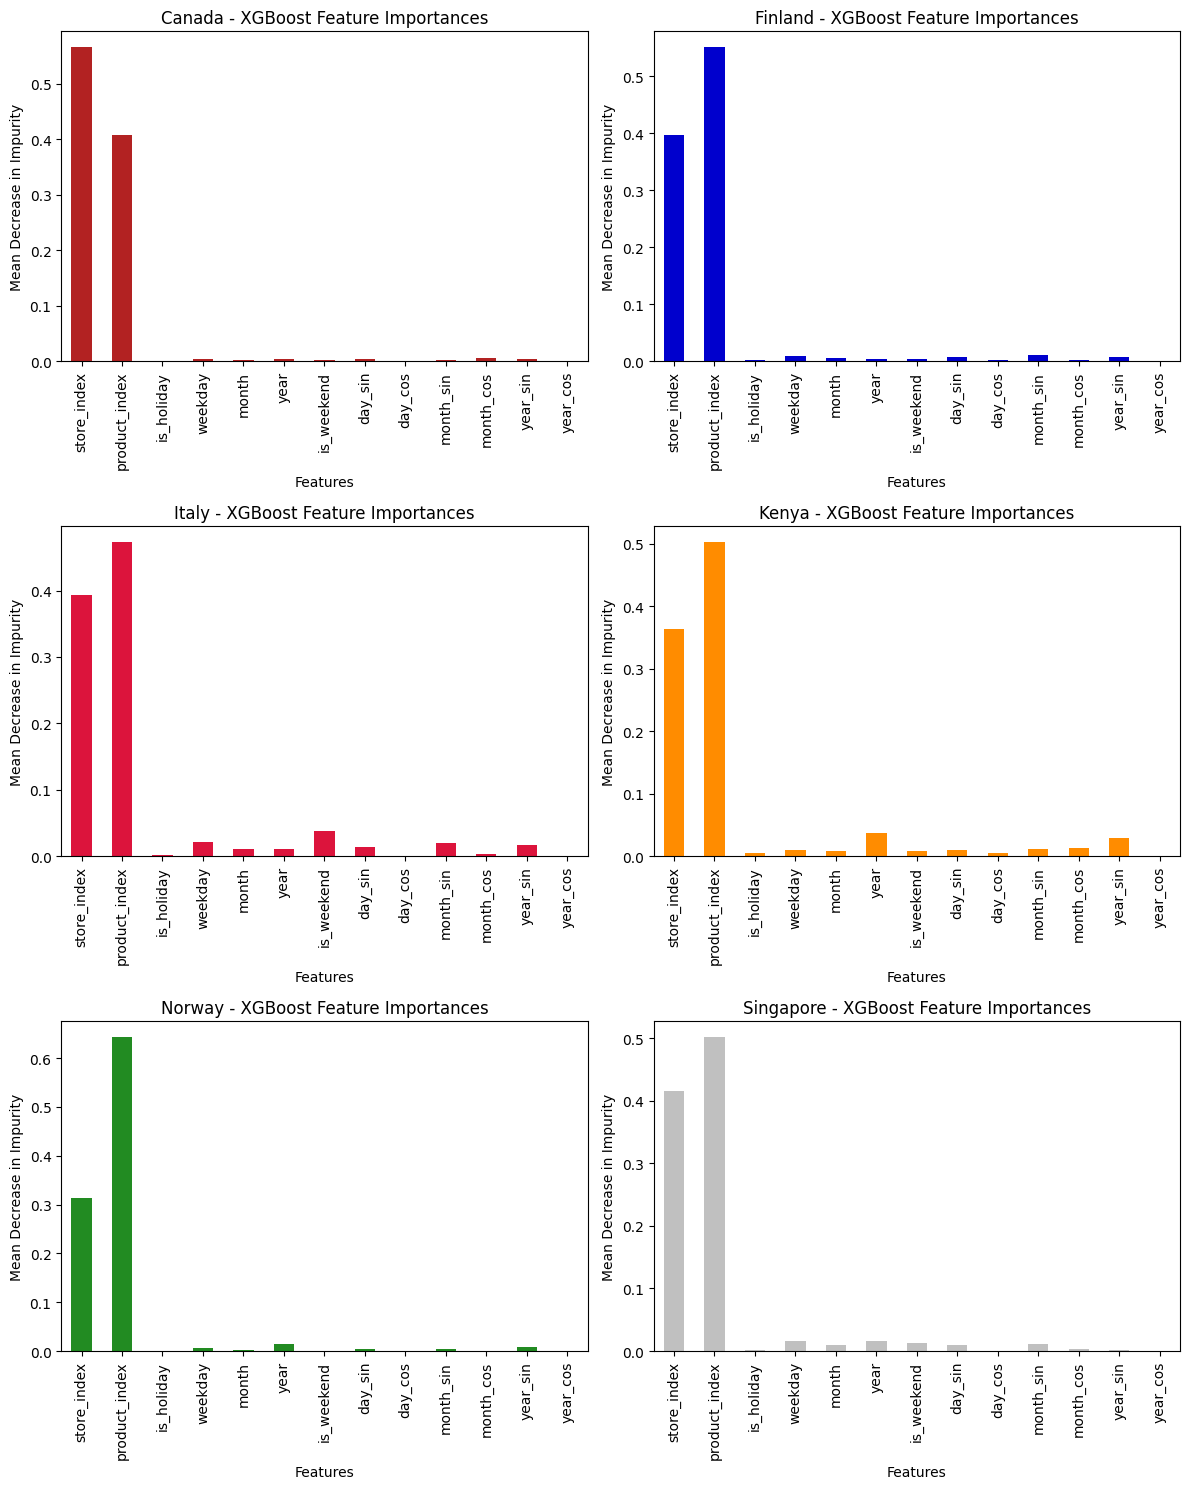

In [ ]:
# Separate plots
fig, axes = plt.subplots(3, 2, figsize = (12, 15))

# Access feature importances from the trained model for the last processed country
canada_importances = results['Canada']['model'].feature_importances_
finland_importances = results['Finland']['model'].feature_importances_
italy_importances = results['Italy']['model'].feature_importances_
kenya_importances = results['Kenya']['model'].feature_importances_
norway_importances = results['Norway']['model'].feature_importances_
singapore_importances = results['Singapore']['model'].feature_importances_

# Create a Pandas Series for plotting
xgb_canada_importances = pd.Series(canada_importances, index=X_test.columns)
xgb_finland_importances = pd.Series(finland_importances, index=X_test.columns)
xgb_italy_importances = pd.Series(italy_importances, index=X_test.columns)
xgb_kenya_importances = pd.Series(kenya_importances, index=X_test.columns)
xgb_norway_importances = pd.Series(norway_importances, index=X_test.columns)
xgb_singapore_importances = pd.Series(singapore_importances, index=X_test.columns)

# Plot subplots
xgb_canada_importances.plot.bar(ax=axes[0, 0], color = 'firebrick')
axes[0, 0].set_title('Canada - XGBoost Feature Importances')
axes[0, 0].set_xlabel('Features')
axes[0, 0].set_ylabel('Mean Decrease in Impurity')

xgb_finland_importances.plot.bar(ax=axes[0, 1], color = 'mediumblue')
axes[0, 1].set_title('Finland - XGBoost Feature Importances')
axes[0, 1].set_xlabel('Features')
axes[0, 1].set_ylabel('Mean Decrease in Impurity')

xgb_italy_importances.plot.bar(ax=axes[1, 0], color = 'crimson')
axes[1, 0].set_title('Italy - XGBoost Feature Importances')
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Mean Decrease in Impurity')

xgb_kenya_importances.plot.bar(ax=axes[1, 1], color = 'darkorange')
axes[1, 1].set_title('Kenya - XGBoost Feature Importances')
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Mean Decrease in Impurity')

xgb_norway_importances.plot.bar(ax=axes[2, 0], color = 'forestgreen')
axes[2, 0].set_title('Norway - XGBoost Feature Importances')
axes[2, 0].set_xlabel('Features')
axes[2, 0].set_ylabel('Mean Decrease in Impurity')

xgb_singapore_importances.plot.bar(ax=axes[2, 1], color = 'silver')
axes[2, 1].set_title('Singapore - XGBoost Feature Importances')
axes[2, 1].set_xlabel('Features')
axes[2, 1].set_ylabel('Mean Decrease in Impurity')

plt.tight_layout()
plt.show()

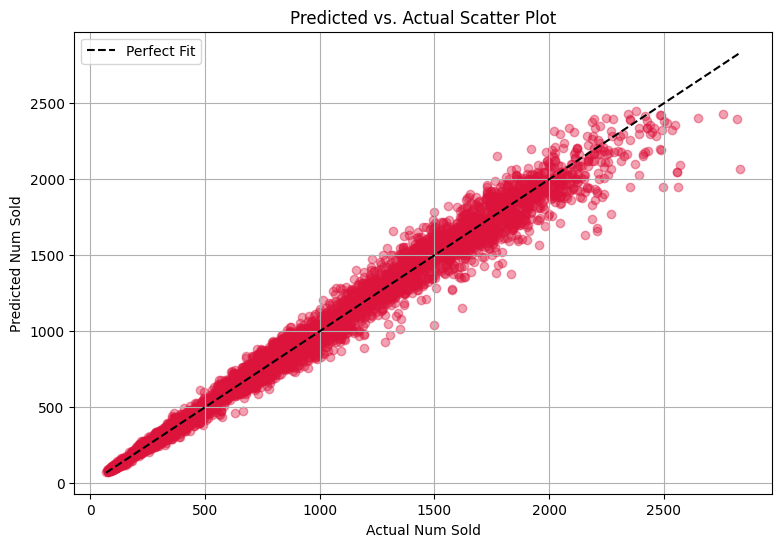

In [ ]:
# Plot for trend analysis
plt.figure(figsize = (9, 6))
plt.scatter(y_test, y_pred, alpha = 0.4, color = "crimson")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         linestyle = "--", color = "black", label = "Perfect Fit")

plt.xlabel("Actual Num Sold")
plt.ylabel("Predicted Num Sold")
plt.title("Predicted vs. Actual Scatter Plot")

plt.legend()
plt.grid(True)
plt.show()

**Remarks:**  
1. *Strong Linear Relationship:* The points closely follow the dashed black "Perfect Fit" line, indicating that the predicted values align well with the actual values.
2. *Minimal Dispersion (Low Prediction Error):* The data points are clustered around the diagonal, showing that the predictions are accurate with low residual errors.  
3. *Symmetry Around the Line:* No significant deviation above or below the line, meaning no strong signs of over-prediction or under-prediction across the range of values.

In [ ]:
# Initialize an empty list to store results
results_list = []

# Store results for the 3rd model
for country, metrics in results.items():
    results_list.append({"Country": country,
                         "RMSE": round(metrics["rmse"], 3),
                         "MAE": round(metrics["mae"], 3),
                         "MAPE(%)": round(metrics["mape"], 3),
                         "R² Score": round(metrics["r2"], 3)})

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Calculate Accuracy (%) as 100 - MAPE
results_df["Accuracy(%)"] = round(100 - results_df["MAPE(%)"], 3)

# Sort by MAPE
results_df = results_df.sort_values(by = ["MAPE(%)"]).reset_index(drop = True)
results_df

,Country,RMSE,MAE,MAPE(%),R² Score,Accuracy(%)
0,Italy,43.028,27.032,0.051,0.985,99.949
1,Singapore,68.871,43.986,0.052,0.985,99.948
2,Finland,64.670,39.891,0.054,0.983,99.946
3,Norway,123.873,75.427,0.054,0.983,99.946
4,Canada,107.046,53.537,0.090,0.945,99.910
5,Kenya,2.531,1.376,0.091,0.951,99.909


### XGBoost Model No.2
**Country-Wise Training**

In [ ]:
# Define features and target variable
features_2 = ['store_index', 'product_index', 'weekday', 'month', 'year',
              'is_weekend', 'day_sin', 'month_sin', 'month_cos', 'year_sin']
target = 'num_sold'

# Step 1: Split data by country for separate modeling
countries = df['country'].unique()  # Extract unique country names

# Store results for each country
results_2 = {}

# Loop through each country to train a separate model
for country in countries:
    print(f"Processing country: {country}")

    # Filter data for the specific country
    country_data = df[df['country'] == country]
    X = country_data[features_2]
    y = country_data[target]

    # Split the country-specific data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = 0.2,
                                                        random_state = 42)

    # Step 2: Define an Optuna objective function for hyperparameter tuning
    def objective_2(trial):
        # Define the hyperparameter search space
        param = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 90, 1400),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'random_state': 42}

        # Train an XGBoost model with the trial parameters
        model_2 = xgb.XGBRegressor(**param)
        model_2.fit(X_train, y_train)

        # Evaluate using the MAPE on the test set
        y_pred2 = model_2.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred2)
        return mape

    # Step 3: Run Optuna optimization
    print("Starting Optuna optimization...")
    study_2 = optuna.create_study(direction = 'minimize')  # Minimize MAPE
    study_2.optimize(objective_2, n_trials = 50, show_progress_bar = True)

    # Best hyperparameters
    best_params_2 = study_2.best_params
    print(f"Best params for {country}: {best_params_2}")

    # Step 4: Train the final model using the best parameters
    print("Training final model with best parameters...")
    final_model_2 = xgb.XGBRegressor(**best_params_2)
    final_model_2.fit(X_train, y_train)

    # Step 5: Make predictions and evaluate the final model
    y_pred2 = final_model_2.predict(X_test)
    mse_2 = mean_squared_error(y_test, y_pred2)
    rmse_2 = np.sqrt(mse_2)
    mae_2 = mean_absolute_error(y_test, y_pred2)
    mape_2 = mean_absolute_percentage_error(y_test, y_pred2)
    r2_2 = r2_score(y_test, y_pred2)

    print(f"Evaluation for {country} - MSE: {mse_2}, RMSE: {rmse_2}, MAE: {mae_2}, MAPE: {mape_2}, R2: {r2_2}")

    # Step 6: Store results for each country
    results_2[country] = {'model': final_model_2,
                          'mse': mse_2,
                          'rmse': rmse_2,
                          'mae': mae_2,
                          'mape': mape_2,
                          'r2': r2_2,
                          'best_params': best_params_2}

# Step 7: Summarize results for all countries
print("\nFinal Results:")
for country, metrics in results_2.items():
    print(f"{country} - MSE: {metrics['mse']}, RMSE: {metrics['rmse']}, MAE: {metrics['mae']}, MAPE: {metrics['mape']}, R2: {metrics['r2']}")

[I 2025-01-30 11:50:58,426] A new study created in memory with name: no-name-06635c9a-0df6-4d45-ae2f-e6f2c91807e7


Processing country: Canada
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:50:58,900] Trial 0 finished with value: 0.10161493209791253 and parameters: {'n_estimators': 146, 'learning_rate': 0.2699707498470585, 'max_depth': 7, 'subsample': 0.6244494973131447, 'colsample_bytree': 0.6479434013789682}. Best is trial 0 with value: 0.10161493209791253.
[I 2025-01-30 11:51:06,163] Trial 1 finished with value: 0.09191047163746345 and parameters: {'n_estimators': 1061, 'learning_rate': 0.046597344820051796, 'max_depth': 8, 'subsample': 0.7665518534040443, 'colsample_bytree': 0.8978817097567562}. Best is trial 1 with value: 0.09191047163746345.
[I 2025-01-30 11:51:10,494] Trial 2 finished with value: 0.0959329778243247 and parameters: {'n_estimators': 1370, 'learning_rate': 0.019303852184098812, 'max_depth': 8, 'subsample': 0.6455209051125887, 'colsample_bytree': 0.6679928478347121}. Best is trial 1 with value: 0.09191047163746345.
[I 2025-01-30 11:51:11,809] Trial 3 finished with value: 0.10432518942857309 and parameters: {'n_estimators': 720, 'learni

[I 2025-01-30 11:54:28,031] A new study created in memory with name: no-name-d7b807ea-fd4c-4368-90fc-4888ec3fc3fd


Evaluation for Canada - MSE: 10955.894941176042, RMSE: 104.67041101082981, MAE: 52.20352602437144, MAPE: 0.08825002354314992, R2: 0.9469526674153191
Processing country: Finland
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:54:29,979] Trial 0 finished with value: 0.07744183887057356 and parameters: {'n_estimators': 449, 'learning_rate': 0.0479606274679973, 'max_depth': 3, 'subsample': 0.6001460165076207, 'colsample_bytree': 0.9571752407009126}. Best is trial 0 with value: 0.07744183887057356.
[I 2025-01-30 11:54:32,574] Trial 1 finished with value: 0.06079842478949594 and parameters: {'n_estimators': 1012, 'learning_rate': 0.2852919535832788, 'max_depth': 7, 'subsample': 0.7968156148865543, 'colsample_bytree': 0.5741287421507065}. Best is trial 1 with value: 0.06079842478949594.
[I 2025-01-30 11:54:34,737] Trial 2 finished with value: 0.057354229191635756 and parameters: {'n_estimators': 1267, 'learning_rate': 0.11866935705875528, 'max_depth': 5, 'subsample': 0.9792304978779912, 'colsample_bytree': 0.7745094230279467}. Best is trial 2 with value: 0.057354229191635756.
[I 2025-01-30 11:54:39,588] Trial 3 finished with value: 0.06261364979100541 and parameters: {'n_estimators': 1218, 'learn

[I 2025-01-30 11:57:20,228] A new study created in memory with name: no-name-fef44bbe-bb7f-4e38-bd1c-91cee4ae21f5


Evaluation for Finland - MSE: 4588.610410161533, RMSE: 67.73928262213538, MAE: 41.24437724463928, MAPE: 0.056030871738685234, R2: 0.9808384595684498
Processing country: Italy
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:57:22,699] Trial 0 finished with value: 0.055163969156615124 and parameters: {'n_estimators': 909, 'learning_rate': 0.07345353105957042, 'max_depth': 7, 'subsample': 0.7670491277399989, 'colsample_bytree': 0.973987862367957}. Best is trial 0 with value: 0.055163969156615124.
[I 2025-01-30 11:57:34,347] Trial 1 finished with value: 0.058599013424541865 and parameters: {'n_estimators': 885, 'learning_rate': 0.017455151530397253, 'max_depth': 13, 'subsample': 0.8147946166351272, 'colsample_bytree': 0.8709124835011144}. Best is trial 0 with value: 0.055163969156615124.
[I 2025-01-30 11:57:35,628] Trial 2 finished with value: 0.05587037669452598 and parameters: {'n_estimators': 871, 'learning_rate': 0.05296692361753541, 'max_depth': 4, 'subsample': 0.9393476228202513, 'colsample_bytree': 0.9297291414371238}. Best is trial 0 with value: 0.055163969156615124.
[I 2025-01-30 11:57:36,747] Trial 3 finished with value: 0.058681239160328254 and parameters: {'n_estimators': 206, 'l

[I 2025-01-30 11:59:24,490] A new study created in memory with name: no-name-90811bb5-685d-452e-aeec-59be8aab69b2


Evaluation for Italy - MSE: 2025.220879886174, RMSE: 45.00245415403669, MAE: 27.86816749279354, MAPE: 0.05200231831556415, R2: 0.9840460332213323
Processing country: Kenya
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 11:59:32,237] Trial 0 finished with value: 0.09810430630445909 and parameters: {'n_estimators': 1192, 'learning_rate': 0.23433528258586883, 'max_depth': 9, 'subsample': 0.7553015753278587, 'colsample_bytree': 0.7913538467710616}. Best is trial 0 with value: 0.09810430630445909.
[I 2025-01-30 11:59:38,701] Trial 1 finished with value: 0.09599760712465778 and parameters: {'n_estimators': 1255, 'learning_rate': 0.10322789741781087, 'max_depth': 10, 'subsample': 0.8509147757982922, 'colsample_bytree': 0.780545879922538}. Best is trial 1 with value: 0.09599760712465778.
[I 2025-01-30 12:00:00,954] Trial 2 finished with value: 0.09680974018967052 and parameters: {'n_estimators': 1128, 'learning_rate': 0.1265117278021672, 'max_depth': 14, 'subsample': 0.8802456134394512, 'colsample_bytree': 0.8785376551539674}. Best is trial 1 with value: 0.09599760712465778.
[I 2025-01-30 12:00:01,680] Trial 3 finished with value: 0.09473314282982384 and parameters: {'n_estimators': 134, 'learn

[I 2025-01-30 12:02:05,313] A new study created in memory with name: no-name-96a201f6-987d-483f-93e1-8834b50b715d


Evaluation for Kenya - MSE: 6.155984177305853, RMSE: 2.4811255867661863, MAE: 1.359005005976162, MAPE: 0.09109063589086491, R2: 0.9529214925966092
Processing country: Norway
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 12:02:08,307] Trial 0 finished with value: 0.0631049094581631 and parameters: {'n_estimators': 571, 'learning_rate': 0.2815481718101737, 'max_depth': 10, 'subsample': 0.7132282132799579, 'colsample_bytree': 0.7415568156467913}. Best is trial 0 with value: 0.0631049094581631.
[I 2025-01-30 12:02:11,704] Trial 1 finished with value: 0.05610831015733062 and parameters: {'n_estimators': 936, 'learning_rate': 0.03793836226145155, 'max_depth': 7, 'subsample': 0.5735326835073299, 'colsample_bytree': 0.5961152536049013}. Best is trial 1 with value: 0.05610831015733062.
[I 2025-01-30 12:02:14,770] Trial 2 finished with value: 0.05856253202798882 and parameters: {'n_estimators': 997, 'learning_rate': 0.15483481552699707, 'max_depth': 4, 'subsample': 0.8392034380781908, 'colsample_bytree': 0.884311818277888}. Best is trial 1 with value: 0.05610831015733062.
[I 2025-01-30 12:02:16,326] Trial 3 finished with value: 0.061919202846764956 and parameters: {'n_estimators': 221, 'learning_r

[I 2025-01-30 12:04:50,971] A new study created in memory with name: no-name-cdb84bc2-2af7-41b6-bc21-df3efe761b97


Evaluation for Norway - MSE: 15530.82119207331, RMSE: 124.62271539359632, MAE: 75.13058571236772, MAPE: 0.053145258749763245, R2: 0.982874791480019
Processing country: Singapore
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-30 12:04:52,079] Trial 0 finished with value: 0.05622198527159451 and parameters: {'n_estimators': 406, 'learning_rate': 0.21514889342382904, 'max_depth': 7, 'subsample': 0.9727609752407427, 'colsample_bytree': 0.5981654534739983}. Best is trial 0 with value: 0.05622198527159451.
[I 2025-01-30 12:04:52,613] Trial 1 finished with value: 0.05675837539614744 and parameters: {'n_estimators': 106, 'learning_rate': 0.12005160829744117, 'max_depth': 10, 'subsample': 0.6011215868010376, 'colsample_bytree': 0.6574571145603061}. Best is trial 0 with value: 0.05622198527159451.
[I 2025-01-30 12:04:56,639] Trial 2 finished with value: 0.06930011415166187 and parameters: {'n_estimators': 1185, 'learning_rate': 0.25613642806156184, 'max_depth': 3, 'subsample': 0.5727640576776538, 'colsample_bytree': 0.5221852390412786}. Best is trial 0 with value: 0.05622198527159451.
[I 2025-01-30 12:04:57,439] Trial 3 finished with value: 0.07260545732839416 and parameters: {'n_estimators': 472, 'learni

In [ ]:
# Initialize an empty list to store results
results_list = []
# Store results for the second model
for country, metrics in results_2.items():
    results_list.append({
        "Country": country,
        "RMSE": round(metrics["rmse"], 3),
        "MAE": round(metrics["mae"], 3),
        "MAPE(%)": round(metrics["mape"], 3),
        "R² Score": round(metrics["r2"], 3)})

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Calculate Accuracy (%) as 100 - MAPE
results_df["Accuracy(%)"] = round(100 - results_df["MAPE(%)"], 3)

# Sort
results_df = results_df.sort_values(by = ["MAPE(%)"]).reset_index(drop = True)

from IPython.display import display
display(results_df)

,Country,RMSE,MAE,MAPE(%),R² Score,Accuracy(%)
0,Italy,45.002,27.868,0.052,0.984,99.948
1,Norway,124.623,75.131,0.053,0.983,99.947
2,Singapore,71.004,44.889,0.053,0.984,99.947
3,Finland,67.739,41.244,0.056,0.981,99.944
4,Canada,104.670,52.204,0.088,0.947,99.912
5,Kenya,2.481,1.359,0.091,0.953,99.909


In [ ]:
# Save model as dictionary
# 'results' contains the trained models for each country
file_name = "2nd_xgb_models_dict.pkl"

# Extract only the models from results and store them in a dictionary
models_dict_2 = {country: results_2[country]['model'] for country in results_2}

# Save the dictionary of models
with open(file_name, "wb") as f:
    pickle.dump(models_dict_2, f)

print("✅ Models saved as dictionary!")

✅ Models saved as dictionary!


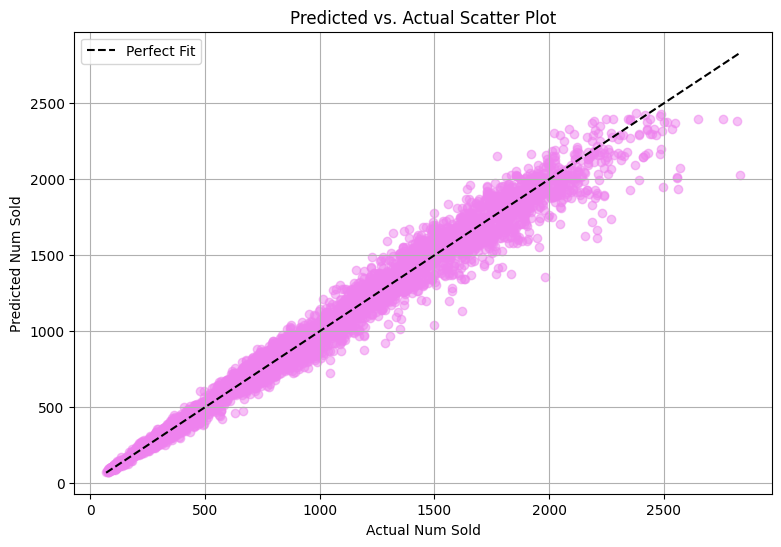

In [ ]:
# Plot for trend analysis
plt.figure(figsize = (9, 6))
plt.scatter(y_test, y_pred2, alpha = 0.5, color = "violet")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         linestyle = "--", color = "black", label = "Perfect Fit")

plt.xlabel("Actual Num Sold")
plt.ylabel("Predicted Num Sold")
plt.title("Predicted vs. Actual Scatter Plot")

plt.legend()
plt.grid(True)
plt.show()

### XGBoost Model No.3
**Product-Wise Training**

In [ ]:
# Define features and target variable
features_3 = ['store_index', 'country_index', 'is_holiday', 'weekday', 'month',
              'year', 'is_weekend', 'day_sin', 'day_cos', 'month_sin',
              'month_cos', 'year_sin', 'year_cos']
target = 'num_sold'

# Step 1: Split data by product for separate modeling
products = df['product'].unique()  # Extract unique product names

# Store results for each product
results_3 = {}

# Loop through each product to train a separate model
for product in products:
    print(f"Processing product: {product}")

    # Filter data for the specific product
    product_data = df[df['product'] == product]
    X = product_data[features_3]
    y = product_data[target]

    # Split the product-specific data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = 0.2,
                                                        random_state = 42)

    # Step 2: Define an Optuna objective function for hyperparameter tuning
    def objective_3(trial):
        # Define the hyperparameter search space
        param = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'random_state': 42}

        # Train an XGBoost model with the trial parameters
        model_3 = xgb.XGBRegressor(**param)
        model_3.fit(X_train, y_train)

        # Evaluate using the MAPE on the test set
        y_pred3 = model_3.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred3)
        return mape

    # Step 3: Run Optuna optimization
    print("Starting Optuna optimization...")
    study_3 = optuna.create_study(direction = 'minimize')
    study_3.optimize(objective_3, n_trials = 50, show_progress_bar = True)

    # Best hyperparameters
    best_params_3 = study_3.best_params
    print(f"Best params for {product}: {best_params_3}")

    # Step 4: Train the final model using the best parameters
    print("Training final model with best parameters...")
    final_model_3 = xgb.XGBRegressor(**best_params_3)
    final_model_3.fit(X_train, y_train)

    # Step 5: Make predictions and evaluate the final model
    y_pred3 = final_model_3.predict(X_test)
    mse_3 = mean_squared_error(y_test, y_pred3)
    rmse_3 = np.sqrt(mse_3)
    mae_3 = mean_absolute_error(y_test, y_pred3)
    mape_3 = mean_absolute_percentage_error(y_test, y_pred3)
    r2_3 = r2_score(y_test, y_pred3)

    print(f"Evaluation for {product} - MSE: {mse_3}, RMSE: {rmse_3}, MAE: {mae_3}, MAPE: {mape_3}, R2: {r2_3}")

    # Step 6: Store results for each product
    results_3[product] = {'model': final_model_3,
                          'mse': mse_3,
                          'rmse': rmse_3,
                          'mae': mae_3,
                          'mape': mape_3,
                          'r2': r2_3,
                          'best_params': best_params_3}

# Step 7: Summarize results for all products
print("\nFinal Results:")
for product, metrics in results_3.items():
    print(f"{product} - MSE: {metrics['mse']}, RMSE: {metrics['rmse']}, MAE: {metrics['mae']}, MAPE: {metrics['mape']}, R2: {metrics['r2']}")

[I 2025-01-29 21:26:57,925] A new study created in memory with name: no-name-aac52c96-ce21-45da-9a00-b33eb0080b55


Processing product: Holographic Goose
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-29 21:27:00,649] Trial 0 finished with value: 0.2635911169904659 and parameters: {'n_estimators': 1419, 'learning_rate': 0.1426889647958082, 'max_depth': 4, 'subsample': 0.6662451466548565, 'colsample_bytree': 0.7362510255865805}. Best is trial 0 with value: 0.2635911169904659.
[I 2025-01-29 21:27:04,589] Trial 1 finished with value: 0.1423296690101789 and parameters: {'n_estimators': 940, 'learning_rate': 0.06671737997424486, 'max_depth': 8, 'subsample': 0.5955814500839129, 'colsample_bytree': 0.9251610632155729}. Best is trial 1 with value: 0.1423296690101789.
[I 2025-01-29 21:27:18,141] Trial 2 finished with value: 0.19856457556964607 and parameters: {'n_estimators': 1440, 'learning_rate': 0.24869618356844966, 'max_depth': 11, 'subsample': 0.5142211404276236, 'colsample_bytree': 0.5689499105062219}. Best is trial 1 with value: 0.1423296690101789.
[I 2025-01-29 21:27:27,023] Trial 3 finished with value: 0.139022463285576 and parameters: {'n_estimators': 391, 'learning_rate

[I 2025-01-29 21:37:59,177] A new study created in memory with name: no-name-28854f98-5336-4a98-abe8-d44031b2d3e6


Evaluation for Holographic Goose - MSE: 5825.722003362671, RMSE: 76.3264174671042, MAE: 20.83303090855905, MAPE: 0.12230532398454327, R2: 0.8544098251161201
Processing product: Kaggle
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-29 21:38:21,771] Trial 0 finished with value: 0.08562411565940109 and parameters: {'n_estimators': 1466, 'learning_rate': 0.23843372931996207, 'max_depth': 12, 'subsample': 0.7389970673251567, 'colsample_bytree': 0.8197195881388586}. Best is trial 0 with value: 0.08562411565940109.
[I 2025-01-29 21:38:26,437] Trial 1 finished with value: 0.09602523576678379 and parameters: {'n_estimators': 500, 'learning_rate': 0.22721919577202987, 'max_depth': 15, 'subsample': 0.7174914166124817, 'colsample_bytree': 0.5026728202772667}. Best is trial 0 with value: 0.08562411565940109.
[I 2025-01-29 21:38:29,419] Trial 2 finished with value: 0.15360830533283765 and parameters: {'n_estimators': 1388, 'learning_rate': 0.2830877152702901, 'max_depth': 4, 'subsample': 0.5181042116808481, 'colsample_bytree': 0.7583208814043687}. Best is trial 0 with value: 0.08562411565940109.
[I 2025-01-29 21:38:33,619] Trial 3 finished with value: 0.28433156569737406 and parameters: {'n_estimators': 1224, 'lear

[I 2025-01-29 21:54:41,327] A new study created in memory with name: no-name-612b4cfc-2363-42e3-98da-22d33b4e423d


Evaluation for Kaggle - MSE: 17220.969977224297, RMSE: 131.2286934219201, MAE: 75.50862161781176, MAPE: 0.06394113789327432, R2: 0.97746512687213
Processing product: Kaggle Tiers
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-29 21:54:42,491] Trial 0 finished with value: 0.09000979985323843 and parameters: {'n_estimators': 186, 'learning_rate': 0.04852556506413777, 'max_depth': 10, 'subsample': 0.8381676831984018, 'colsample_bytree': 0.7109780565187487}. Best is trial 0 with value: 0.09000979985323843.
[I 2025-01-29 21:54:48,401] Trial 1 finished with value: 0.11289898243386717 and parameters: {'n_estimators': 1194, 'learning_rate': 0.260929664274274, 'max_depth': 6, 'subsample': 0.8776637859762126, 'colsample_bytree': 0.7882334491442387}. Best is trial 0 with value: 0.09000979985323843.
[I 2025-01-29 21:54:50,176] Trial 2 finished with value: 0.1389113783217654 and parameters: {'n_estimators': 521, 'learning_rate': 0.07815238512122373, 'max_depth': 7, 'subsample': 0.5784587980371549, 'colsample_bytree': 0.5342112827563564}. Best is trial 0 with value: 0.09000979985323843.
[I 2025-01-29 21:54:56,197] Trial 3 finished with value: 0.08056489233056147 and parameters: {'n_estimators': 1142, 'learning

[I 2025-01-29 22:06:54,135] A new study created in memory with name: no-name-1dcd04c9-96d3-4c57-9134-7f5f198c9bea


Evaluation for Kaggle Tiers - MSE: 10882.812048857326, RMSE: 104.32071725624458, MAE: 61.76384136695823, MAPE: 0.06681649546149337, R2: 0.9793830663536118
Processing product: Kerneler
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-29 22:07:01,468] Trial 0 finished with value: 0.08095768990651384 and parameters: {'n_estimators': 713, 'learning_rate': 0.03474746392991009, 'max_depth': 10, 'subsample': 0.7498150815529786, 'colsample_bytree': 0.7875967875182597}. Best is trial 0 with value: 0.08095768990651384.
[I 2025-01-29 22:07:02,423] Trial 1 finished with value: 0.13985475195712213 and parameters: {'n_estimators': 167, 'learning_rate': 0.26210043828069385, 'max_depth': 10, 'subsample': 0.6775420794353986, 'colsample_bytree': 0.5025937741405864}. Best is trial 0 with value: 0.08095768990651384.
[I 2025-01-29 22:07:04,833] Trial 2 finished with value: 0.07986099836456516 and parameters: {'n_estimators': 706, 'learning_rate': 0.013819915322457204, 'max_depth': 7, 'subsample': 0.8666668241070283, 'colsample_bytree': 0.8275236911576325}. Best is trial 2 with value: 0.07986099836456516.
[I 2025-01-29 22:07:05,577] Trial 3 finished with value: 0.09434951325518852 and parameters: {'n_estimators': 126, 'learn

[I 2025-01-29 22:17:48,432] A new study created in memory with name: no-name-1bc180a3-d6a9-48d8-8c28-58105d31870b


Evaluation for Kerneler - MSE: 3184.7678793518653, RMSE: 56.43374769897765, MAE: 33.923658831224394, MAPE: 0.06789172074870531, R2: 0.9805732735281989
Processing product: Kerneler Dark Mode
Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-29 22:17:57,009] Trial 0 finished with value: 0.07374011956527003 and parameters: {'n_estimators': 485, 'learning_rate': 0.049930856429175274, 'max_depth': 12, 'subsample': 0.9895195310060263, 'colsample_bytree': 0.9868423455610182}. Best is trial 0 with value: 0.07374011956527003.
[I 2025-01-29 22:17:58,816] Trial 1 finished with value: 0.19938682149593906 and parameters: {'n_estimators': 911, 'learning_rate': 0.10325434435756517, 'max_depth': 4, 'subsample': 0.6139718284418245, 'colsample_bytree': 0.7120198082022362}. Best is trial 0 with value: 0.07374011956527003.
[I 2025-01-29 22:18:00,932] Trial 2 finished with value: 0.22898929101823887 and parameters: {'n_estimators': 1431, 'learning_rate': 0.288937260574236, 'max_depth': 3, 'subsample': 0.9555716837257837, 'colsample_bytree': 0.8662052274199934}. Best is trial 0 with value: 0.07374011956527003.
[I 2025-01-29 22:18:23,271] Trial 3 finished with value: 0.08677464224635875 and parameters: {'n_estimators': 1111, 'learni

In [ ]:
# Initialize an empty list to store results
results_list = []

# Store results for the 3rd model
for product, metrics in results_3.items():
    results_list.append({
        "Product": product,
        "RMSE": round(metrics["rmse"], 3),
        "MAE": round(metrics["mae"], 3),
        "MAPE(%)": round(metrics["mape"], 3),
        "R² Score": round(metrics["r2"], 3)})

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Calculate Accuracy (%) as 100 - MAPE
results_df["Accuracy(%)"] = round(100 - results_df["MAPE(%)"], 3)

# Sort
results_df = results_df.sort_values(by = ["MAPE(%)"]).reset_index(drop = True)
results_df

,Product,RMSE,MAE,MAPE(%),R² Score,Accuracy(%)
0,Kaggle,131.229,75.509,0.064,0.977,99.936
1,Kaggle Tiers,104.321,61.764,0.067,0.979,99.933
2,Kerneler Dark Mode,64.804,37.138,0.067,0.981,99.933
3,Kerneler,56.434,33.924,0.068,0.981,99.932
4,Holographic Goose,76.326,20.833,0.122,0.854,99.878


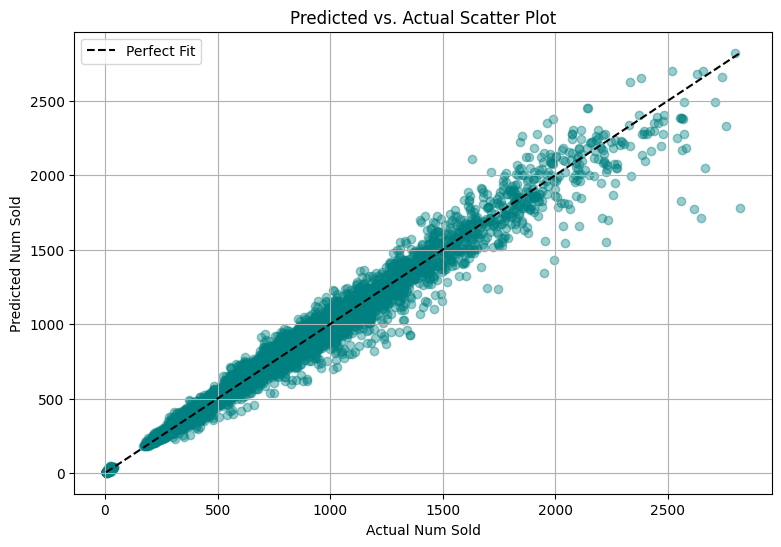

In [ ]:
# Plot for trend analysis
plt.figure(figsize = (9, 6))
plt.scatter(y_test, y_pred3, alpha = 0.4, color = "teal")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         linestyle = "--", color = "black", label = "Perfect Fit")

plt.xlabel("Actual Num Sold")
plt.ylabel("Predicted Num Sold")
plt.title("Predicted vs. Actual Scatter Plot")

plt.legend()
plt.grid(True)
plt.show()

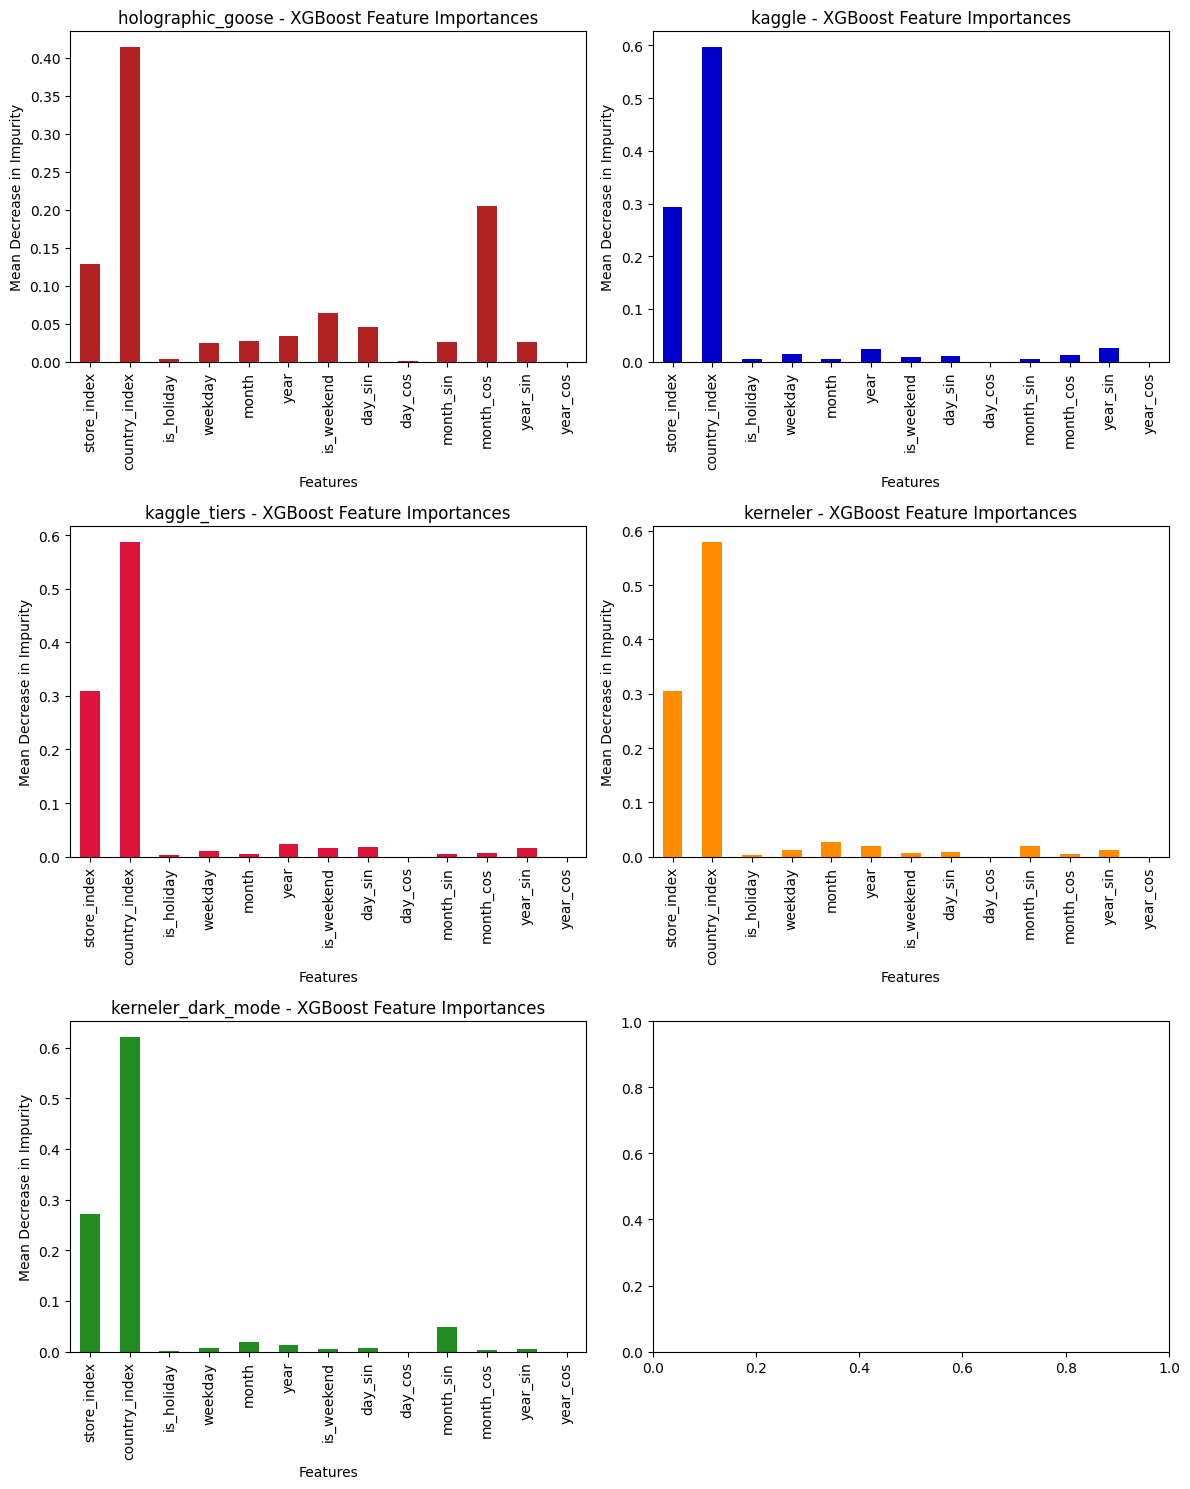

In [ ]:
# Separate plots
fig, axes = plt.subplots(3, 2, figsize = (12, 15))

# Access feature importances from the trained model for the last processed country
holographic_goose_importances = results_3['Holographic Goose']['model'].feature_importances_
kaggle_importances = results_3['Kaggle']['model'].feature_importances_
kaggle_tiers_importances = results_3['Kaggle Tiers']['model'].feature_importances_
kerneler_importances = results_3['Kerneler']['model'].feature_importances_
kerneler_dark_mode_importances = results_3['Kerneler Dark Mode']['model'].feature_importances_

# Create a Pandas Series for plotting
xgb_holographic_goose_importances = pd.Series(holographic_goose_importances, index=X_test.columns)
xgb_kaggle_importances = pd.Series(kaggle_importances, index=X_test.columns)
xgb_kaggle_tiers_importances = pd.Series(kaggle_tiers_importances, index=X_test.columns)
xgb_kerneler_importances = pd.Series(kerneler_importances, index=X_test.columns)
xgb_kerneler_dark_mode_importances = pd.Series(kerneler_dark_mode_importances, index=X_test.columns)

# Plot subplots
xgb_holographic_goose_importances.plot.bar(ax=axes[0, 0], color = 'firebrick')
axes[0, 0].set_title('holographic_goose - XGBoost Feature Importances')
axes[0, 0].set_xlabel('Features')
axes[0, 0].set_ylabel('Mean Decrease in Impurity')

xgb_kaggle_importances.plot.bar(ax=axes[0, 1], color = 'mediumblue')
axes[0, 1].set_title('kaggle - XGBoost Feature Importances')
axes[0, 1].set_xlabel('Features')
axes[0, 1].set_ylabel('Mean Decrease in Impurity')

xgb_kaggle_tiers_importances.plot.bar(ax=axes[1, 0], color = 'crimson')
axes[1, 0].set_title('kaggle_tiers - XGBoost Feature Importances')
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Mean Decrease in Impurity')

xgb_kerneler_importances.plot.bar(ax=axes[1, 1], color = 'darkorange')
axes[1, 1].set_title('kerneler - XGBoost Feature Importances')
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Mean Decrease in Impurity')

xgb_kerneler_dark_mode_importances.plot.bar(ax=axes[2, 0], color = 'forestgreen')
axes[2, 0].set_title('kerneler_dark_mode - XGBoost Feature Importances')
axes[2, 0].set_xlabel('Features')
axes[2, 0].set_ylabel('Mean Decrease in Impurity')

plt.tight_layout()
plt.show()